# XGBoost for Mo Salah

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import namedtuple
import random
from random import sample
from collections import Counter
import numba
import os
%matplotlib inline

In [2]:
from xgboost import XGBRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score
import matplotlib.pyplot as plt 
import xgboost

In [3]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [4]:
data_train = pd.read_csv("/home/pratik/Documents/MSc/Project/Data Preparation/xgboost_tests/mo_salah.csv")
data_test = pd.read_csv("/home/pratik/Documents/MSc/Project/Data Preparation/xgboost_tests/mo_salah_test.csv")
data_train.head(5)

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,...,penalties_missed_ra,own_goals_ra,penalties_saved_ra,red_cards_ra,yellow_cards_ra,goal_difference_ra,Season_1819,Season_1920,Season_2021,Season_2122
0,0,0,20,1,29.0,253,5,0,1,16.9,...,0,0,0,0,0.0,4.000000,1,0,0,0
1,2,0,22,1,41.5,253,15,0,0,15.3,...,0,0,0,0,0.0,4.000000,1,0,0,0
2,0,0,28,1,72.0,253,25,0,1,20.3,...,0,0,0,0,0.0,3.000000,1,0,0,0
3,0,0,7,0,12.5,253,37,1,0,4.1,...,0,0,0,0,0.0,2.333333,1,0,0,0
4,0,0,7,0,31.8,253,48,1,0,12.2,...,0,0,0,0,0.0,2.000000,1,0,0,0


In [5]:
data_test.head(5)

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,...,penalties_missed_ra,own_goals_ra,penalties_saved_ra,red_cards_ra,yellow_cards_ra,goal_difference_ra,Season_1819,Season_1920,Season_2021,Season_2122
0,2,3,49,1,36.4,233,7,0,1,17.7,...,0.0,0,0,0,0.0,3.000000,0,0,0,1
1,0,0,5,1,26.1,233,15,0,0,11.1,...,0.0,0,0,0,0.0,3.000000,0,0,0,1
2,0,3,27,0,45.1,233,23,1,1,14.0,...,0.0,0,0,0,0.0,2.500000,0,0,0,1
3,0,0,28,1,53.2,233,36,0,1,17.7,...,0.0,0,0,0,0.0,1.666667,0,0,0,1
4,1,2,29,1,28.9,233,44,0,1,19.7,...,0.0,0,0,0,0.0,2.000000,0,0,0,1


In [6]:
# data_train = data_train.drop(data_train.loc[:, 'assists':'red_cards'].columns, axis = 1)
data_train = data_train.drop(data_train.loc[:, 'assists':'goals_scored'].columns, axis = 1)
data_train = data_train.drop(data_train.loc[:, 'ict_index':'red_cards'].columns, axis = 1)
data_train = data_train.drop(['saves'], axis = 1)
data_train = data_train.drop(['goal_difference'], axis = 1)
data_train = data_train.drop(data_train.loc[:, 'team_a_score':'threat'].columns, axis = 1)
data_train = data_train.drop(data_train.loc[:, 'transfers_in':'transfers_out'].columns, axis = 1)
data_train = data_train.drop(data_train.loc[:, 'was_home':'opp_team'].columns, axis = 1)
data_train = data_train.drop(['Position','round'], axis = 1)
data_train = data_train.drop(data_train.loc[:, 'Season_1819':'Season_2122'].columns, axis = 1)
data_train.head(5)

,selected,total_points,transfers_balance,value,my_team_strength,opp_team_strength,fixture_gap,bonus_prev_gw,ict_index_prev_gw,was_home_binary,...,goals_conceded_ra,goals_scored_ra,minutes_ra,saves_ra,penalties_missed_ra,own_goals_ra,penalties_saved_ra,red_cards_ra,yellow_cards_ra,goal_difference_ra
0,2478960,8,0,130,5,3,7.000000,0,16.9,1,...,0.00,1.000000,86.000000,0,0,0,0,0,0.0,4.000000
1,2799491,9,38860,130,4,2,8.270833,0,16.9,0,...,0.00,1.000000,86.000000,0,0,0,0,0,0.0,4.000000
2,2892383,8,5370,130,5,2,4.895833,0,15.3,1,...,0.00,0.500000,88.000000,0,0,0,0,0,0.0,3.000000
3,2995784,2,32547,130,4,3,5.791667,0,20.3,0,...,0.00,0.666667,88.666667,0,0,0,0,0,0.0,2.333333
4,2754458,2,-261759,130,4,4,5.000000,0,4.1,0,...,0.25,0.500000,84.000000,0,0,0,0,0,0.0,2.000000


In [7]:
# data_train = data_train.drop(data_train.loc[:, 'assists':'red_cards'].columns, axis = 1)
data_test = data_test.drop(data_test.loc[:, 'assists':'goals_scored'].columns, axis = 1)
data_test = data_test.drop(data_test.loc[:, 'ict_index':'red_cards'].columns, axis = 1)
data_test = data_test.drop(['saves'], axis = 1)
data_test = data_test.drop(['goal_difference'], axis = 1)
data_test = data_test.drop(data_test.loc[:, 'team_a_score':'threat'].columns, axis = 1)
data_test = data_test.drop(data_test.loc[:, 'transfers_in':'transfers_out'].columns, axis = 1)
data_test = data_test.drop(data_test.loc[:, 'was_home':'opp_team'].columns, axis = 1)
data_test = data_test.drop(['Position','round'], axis = 1)
data_test = data_test.drop(data_test.loc[:, 'Season_1819':'Season_2122'].columns, axis = 1)
data_test.head(5)

,selected,total_points,transfers_balance,value,my_team_strength,opp_team_strength,fixture_gap,bonus_prev_gw,ict_index_prev_gw,was_home_binary,...,goals_conceded_ra,goals_scored_ra,minutes_ra,saves_ra,penalties_missed_ra,own_goals_ra,penalties_saved_ra,red_cards_ra,yellow_cards_ra,goal_difference_ra
0,3548693,17,0,125,4,2,7.000000,3,17.7,0,...,0.000000,1.000000,90.0,0,0.0,0,0,0,0.0,3.000000
1,4181298,3,227931,126,5,2,6.791667,3,17.7,1,...,0.000000,1.000000,90.0,0,0.0,0,0,0,0.0,3.000000
2,4031662,10,-203411,126,5,4,7.208333,0,11.1,1,...,0.000000,0.500000,90.0,0,0.0,0,0,0,0.0,2.500000
3,4316524,8,126513,125,4,3,5.000000,3,14.0,0,...,0.333333,0.666667,90.0,0,0.0,0,0,0,0.0,1.666667
4,4498374,12,121907,125,5,3,5.937500,0,17.7,1,...,0.250000,0.750000,90.0,0,0.0,0,0,0,0.0,2.000000


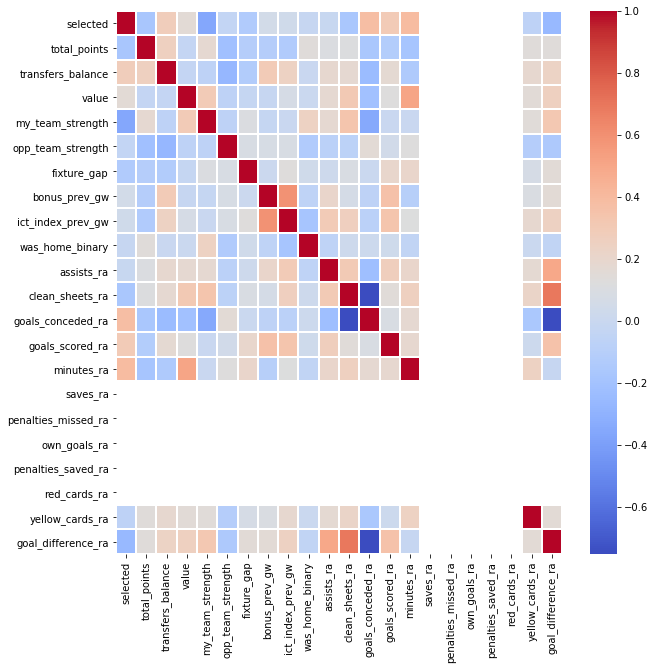

In [8]:
x = plt.subplots(figsize=(10,10))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(data_train.corr(), annot = False, fmt='.2g',cmap= 'coolwarm',linewidths=1)

In [9]:
data_train.corr()

,selected,total_points,transfers_balance,value,my_team_strength,opp_team_strength,fixture_gap,bonus_prev_gw,ict_index_prev_gw,was_home_binary,...,goals_conceded_ra,goals_scored_ra,minutes_ra,saves_ra,penalties_missed_ra,own_goals_ra,penalties_saved_ra,red_cards_ra,yellow_cards_ra,goal_difference_ra
selected,1.000000,-0.174062,0.275123,0.163976,-0.361054,-0.038433,-0.131921,0.049728,0.035140,-0.019549,...,0.377465,0.301301,0.391005,NaN,NaN,NaN,NaN,NaN,-0.067741,-0.255267
total_points,-0.174062,1.000000,0.253800,-0.031374,0.181971,-0.218566,-0.112808,-0.111675,-0.134447,0.138542,...,-0.166945,-0.122266,-0.182116,NaN,NaN,NaN,NaN,NaN,0.137249,0.139841
transfers_balance,0.275123,0.253800,1.000000,-0.034164,-0.062446,-0.272687,-0.123725,0.299212,0.242626,-0.005626,...,-0.241142,0.172094,-0.139664,NaN,NaN,NaN,NaN,NaN,0.191484,0.238186
value,0.163976,-0.031374,-0.034164,1.000000,0.296840,-0.068018,-0.027019,-0.020243,0.069153,0.004451,...,-0.210834,0.127210,0.509489,NaN,NaN,NaN,NaN,NaN,0.151807,0.254409
my_team_strength,-0.361054,0.181971,-0.062446,0.296840,1.000000,-0.061984,0.103251,-0.022266,-0.005711,0.242536,...,-0.346794,-0.002151,-0.005831,NaN,NaN,NaN,NaN,NaN,0.150414,0.321204
opp_team_strength,-0.038433,-0.218566,-0.272687,-0.068018,-0.061984,1.000000,0.088600,0.080454,0.087037,-0.132895,...,0.160925,0.047309,0.123660,NaN,NaN,NaN,NaN,NaN,-0.109680,-0.144473
fixture_gap,-0.131921,-0.112808,-0.123725,-0.027019,0.103251,0.088600,1.000000,0.007068,0.135002,0.037121,...,0.006142,0.199502,0.206354,NaN,NaN,NaN,NaN,NaN,0.069641,0.156701
bonus_prev_gw,0.049728,-0.111675,0.299212,-0.020243,-0.022266,0.080454,0.007068,1.000000,0.595305,-0.058421,...,-0.062562,0.362115,-0.097845,NaN,NaN,NaN,NaN,NaN,0.097306,0.161371
ict_index_prev_gw,0.035140,-0.134447,0.242626,0.069153,-0.005711,0.087037,0.135002,0.595305,1.000000,-0.184659,...,-0.077510,0.337552,0.117935,NaN,NaN,NaN,NaN,NaN,0.190048,0.249124
was_home_binary,-0.019549,0.138542,-0.005626,0.004451,0.242536,-0.132895,0.037121,-0.058421,-0.184659,1.000000,...,0.017049,0.031044,-0.043370,NaN,NaN,NaN,NaN,NaN,0.000000,-0.041884


In [10]:
var_columns = [c for c in data_train.columns if c not in ['total_points','Season_1819','Season_1920','Season_2021','Season_2122','round']]
# var_columns = ['selected','value','my_team_strength','opp_team_strength','fixture_gap','bonus_prev_gw','ict_index_prev_gw','was_home_binary']
X_train = data_train.loc[:, var_columns]
Y_train = data_train.loc[:, 'total_points']
# Y_train = data_train.loc[:, 'goals_scored']

var_columns_test = [c for c in data_test.columns if c not in ['total_points','Season_1819','Season_1920','Season_2021','Season_2122','round']]
# var_columns_test = ['selected','value','my_team_strength','opp_team_strength','fixture_gap','bonus_prev_gw','ict_index_prev_gw','was_home_binary']
X_test = data_test.loc[:, var_columns_test]
Y_test = data_test.loc[:, 'total_points']
# Y_train = data_train.loc[:, 'goals_scored']

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((114, 21), (24, 21), (114,), (24,))

In [12]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [13]:
xgb_reg = XGBRegressor()
random_search=RandomizedSearchCV(xgb_reg,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [158]:
random_search.fit(X_train,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:    8.2s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   10.0s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.1s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monot...
                                          validate_parameters=None,
                                          verbosity=None),
                   iid='deprecated', n_iter=5, n_jobs=-1,
     

In [171]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0.4, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=15, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [172]:
tuned_params = random_search.best_params_

In [173]:
tuned_params

{'min_child_weight': 7,
 'max_depth': 15,
 'learning_rate': 0.3,
 'gamma': 0.4,
 'colsample_bytree': 0.5}

In [174]:
tuned_params['min_child_weight']
tuned_params['max_depth']
tuned_params['learning_rate']
tuned_params['gamma']
tuned_params['colsample_bytree']

0.5

In [175]:
xgb_reg =XGBRegressor(min_child_weight = tuned_params['min_child_weight'], max_depth = tuned_params['max_depth'],
                     learning_rate = tuned_params['learning_rate'], gamma = tuned_params['gamma'],
                     colsample_bytree = tuned_params['colsample_bytree'])

In [176]:
# xgb_reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
#              gamma=0.0, gpu_id=-1, importance_type=None,
#              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
#              max_depth=8, min_child_weight=5,
#              monotone_constraints='()', n_estimators=100, n_jobs=12,
#              num_parallel_tree=1, objective='reg:squarederror',
#              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
#              scale_pos_weight=1, subsample=1, tree_method='exact',
#              validate_parameters=1, verbosity=None)

In [14]:
xgb_reg.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [15]:
Y_pred = xgb_reg.predict(X_test)
Y_pred

array([2.658751 , 6.607944 , 6.051393 , 4.7089324, 3.5003765, 3.0915418,
       5.666192 , 4.3827057, 2.665118 , 1.4312383, 5.9824   , 7.2725997,
       9.011447 , 7.1134925, 5.1006446, 6.584546 , 5.9653397, 7.3510437,
       5.023179 , 4.2882266, 5.167603 , 7.9589386, 4.771476 , 5.931561 ],
      dtype=float32)

In [16]:
sum_pred = 0
sum_test = 0
for i in range(len(Y_pred)):
    Y_pred[i] = round(Y_pred[i])
    sum_pred += Y_pred[i]
    sum_test += Y_test[i]
    Y_pred[i] = round(Y_pred[i])
Y_pred, list(Y_test), sum_pred, sum_test

(array([3., 7., 6., 5., 4., 3., 6., 4., 3., 1., 6., 7., 9., 7., 5., 7., 6.,
        7., 5., 4., 5., 8., 5., 6.], dtype=float32),
 [17,
  3,
  10,
  8,
  12,
  7,
  13,
  13,
  24,
  5,
  5,
  8,
  6,
  15,
  6,
  8,
  8,
  2,
  0,
  7,
  0,
  0,
  1,
  3],
 129.0,
 181)

In [180]:
mse = mean_squared_error(Y_test, Y_pred)
mse

52.75

In [181]:
rmse = np.sqrt(mse)
rmse

7.262919523166975

In [214]:
column_names = ["player_name"]
for i in range(30):
    if i+1 < 10:
        col = "gw_0"+str(i+1)+"_pred"
    else:
        col = "gw_"+str(i+1)+"_pred"
    column_names.append(col)
column_names.append("total_predicted")
column_names.append("actual_points")
column_names.append("rmse")
df = pd.DataFrame(columns = column_names)
df.head()


,player_name,gw_01_pred,gw_02_pred,gw_03_pred,gw_04_pred,gw_05_pred,gw_06_pred,gw_07_pred,gw_08_pred,gw_09_pred,gw_10_pred,gw_11_pred,gw_12_pred,gw_13_pred,gw_14_pred,gw_15_pred,gw_16_pred,gw_17_pred,gw_18_pred,gw_19_pred,gw_20_pred,gw_21_pred,gw_22_pred,gw_23_pred,gw_24_pred,gw_25_pred,gw_26_pred,gw_27_pred,gw_28_pred,gw_29_pred,gw_30_pred,total_predicted,actual_points,rmse


In [216]:
data = []


for j in range(2):
    row_data = []
    for i in range(len(column_names)):
        if column_names[i] == "player_name":
            row_data.append("Mo Salah")
        elif column_names[i] == "total_predicted":
            row_data.append(sum_pred)
        elif column_names[i] == "actual_points":
            row_data.append(sum_test)
        elif column_names[i] == "rmse":
            row_data.append(rmse)
        else:
            try:
                row_data.append(Y_pred[int(column_names[i][3:5]) - 1])
            except:
                row_data.append("NP")
                
#             if int(column_names[i][3:5]) >= len(column_names) - 4:
#                 row_data.append("NP")
#             else:
#                 row_data.append(Y_pred[int(column_names[i][3:5]) - 1])

    data.append(row_data)
# print(data)
df = pd.DataFrame(data, columns = column_names)   
df

,player_name,gw_01_pred,gw_02_pred,gw_03_pred,gw_04_pred,gw_05_pred,gw_06_pred,gw_07_pred,gw_08_pred,gw_09_pred,gw_10_pred,gw_11_pred,gw_12_pred,gw_13_pred,gw_14_pred,gw_15_pred,gw_16_pred,gw_17_pred,gw_18_pred,gw_19_pred,gw_20_pred,gw_21_pred,gw_22_pred,gw_23_pred,gw_24_pred,gw_25_pred,gw_26_pred,gw_27_pred,gw_28_pred,gw_29_pred,gw_30_pred,total_predicted,actual_points,rmse
0,Mo Salah,2.0,3.0,6.0,3.0,5.0,4.0,7.0,3.0,2.0,3.0,2.0,3.0,4.0,3.0,5.0,6.0,8.0,6.0,2.0,2.0,6.0,5.0,4.0,7.0,NP,NP,NP,NP,NP,NP,101.0,181,7.26292
1,Mo Salah,2.0,3.0,6.0,3.0,5.0,4.0,7.0,3.0,2.0,3.0,2.0,3.0,4.0,3.0,5.0,6.0,8.0,6.0,2.0,2.0,6.0,5.0,4.0,7.0,NP,NP,NP,NP,NP,NP,101.0,181,7.26292


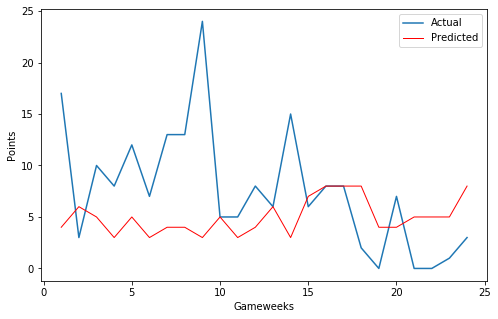

In [170]:
x = np.linspace(1,24, 24)
plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, Y_test)
plt.plot(x, Y_pred, 
         color='red',   
         linewidth=1.0,  
         linestyle='-' 
        )
plt.xlabel("Gameweeks")
plt.ylabel("Points")
plt.legend(["Actual", "Predicted"], loc ="upper right")
  
plt.show()